In [137]:
import itertools
import random

import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import tensorflow as tf
import sentencepiece as spm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from tokenization_and_embedding import TokenAndPositionEmbedding
from transformer_block import TransformerBlock

# Dataset https://www.kaggle.com/code/aadyasingh55/model-training-of-tweet-emotion-classification

In [138]:
df = pd.read_parquet('data.parquet')

print(df.head())
print(df['label'])

# Map the labels to emotion names for better readability (Optional)
emotion_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
df['emotion'] = df['label'].map(emotion_map)

# Preview the updated dataframe
print(df[['text', 'emotion']].head())

                                                text  label
0  i feel awful about it too because it s my job ...      0
1                              im alone i feel awful      0
2  ive probably mentioned this before but i reall...      1
3           i was feeling a little low few days back      0
4  i beleive that i am much more sensitive to oth...      2
0         0
1         0
2         1
3         0
4         2
         ..
416804    1
416805    4
416806    0
416807    1
416808    0
Name: label, Length: 416809, dtype: int64
                                                text  emotion
0  i feel awful about it too because it s my job ...  sadness
1                              im alone i feel awful  sadness
2  ive probably mentioned this before but i reall...      joy
3           i was feeling a little low few days back  sadness
4  i beleive that i am much more sensitive to oth...     love


In [ ]:
### Constants

# Training Vars
EPOCHS = 5
PATIENCE = 2
BATCH_SIZE = 64
LEARNING_RATE = 3e-4

# Model vars
EMBED_DIM = 128
NUM_HEADS = 4
FF_DIM = 256
DENSE_UNITS = 128
DROPOUT = 0.1

SEEDS = [42, 7]

# Params Grid
sweep = {
    "num_layers": [1, 2],
    "num_heads": [4],
    "ff_dim": [256],
    "dropout": [0.1, 0.2],
    "lr": [3e-4, 1e-4],
    "dense_units": [128],
}


EIGHT_THOUSAND = 8000
SIXTEEN_THOUSAND = 16000
# NUMBER_OF_LAYERS = 2 # not use while testing params table
TRAIN_TEXT = 'train_text.txt'
LABEL_FILE = 'train_labels.txt'
SAMPLE_TEXT = "This is a sample sentence used for BPE bits. It can be up to 128 characters long."
TOKEN_LENGTH = 128

In [140]:

def set_all_seeds(seed: int):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)


In [141]:
#BASIC PRE PROCESSING
print(df.shape)
print(df.columns)
print(f"Data Types: {df.dtypes}")
print(f"Empty values {df.isna().sum()}")
print(f"Duplicates: {df.duplicated().sum()}")
print(df["label"].value_counts())
print(df["label"].value_counts(normalize=True).round(3))

(416809, 3)
Index(['text', 'label', 'emotion'], dtype='object')
Data Types: text       object
label       int64
emotion    object
dtype: object
Empty values text       0
label      0
emotion    0
dtype: int64
Duplicates: 686
label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64
label
1    0.338
0    0.291
3    0.138
4    0.114
2    0.083
5    0.036
Name: proportion, dtype: float64


In [142]:
from sklearn.model_selection import train_test_split

X = df["text"].astype(str)
y = df["label"].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Second split to obtain validation as well as test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Feature Distribution (After Stratification)")
print(f"Train(%): {y_train.value_counts(normalize=True).round(5).sort_index() * 100}\n")
print(f"Val(%): {y_val.value_counts(normalize=True).round(5).sort_index() * 100}\n")
print(f"Test(%): {y_test.value_counts(normalize=True).round(5).sort_index() * 100}\n")

Feature Distribution (After Stratification)
Train(%): label
0    29.075
1    33.844
2     8.290
3    13.752
4    11.447
5     3.592
Name: proportion, dtype: float64

Val(%): label
0    29.076
1    33.845
2     8.289
3    13.752
4    11.446
5     3.592
Name: proportion, dtype: float64

Test(%): label
0    29.076
1    33.845
2     8.292
3    13.750
4    11.446
5     3.592
Name: proportion, dtype: float64



In [143]:
text_lengths = X_train.str.split().apply(len)
print(text_lengths.describe())

KeyboardInterrupt: 

In [ ]:
X_train_clean = X_train.str.strip()
X_val_clean = X_val.str.strip()
X_test_clean = X_test.str.strip()

X_train_clean.to_csv(TRAIN_TEXT, index=False, header=False)
print(f"Wrote {len(X_train_clean)} to file")

Wrote 333447 to file


In [ ]:
### Byte Pair Encoding (BPE)
spm.SentencePieceTrainer.train(
    input=TRAIN_TEXT,
    model_prefix='m_bpe',
    vocab_size=EIGHT_THOUSAND,
    model_type='bpe',
    pad_id=3,
    unk_id=0,
    bos_id=1,
    eos_id=2
)

sp_bpe = spm.SentencePieceProcessor()
sp_bpe.load('m_bpe.model')

print(f"Vocab size: {sp_bpe.get_piece_size()}")
print(f"BPE Pieces: {sp_bpe.encode(SAMPLE_TEXT, out_type=str)[:20]}")

def encode_texts(sp, texts):
  """
  Encode text, create token IDs and attention masks
  """
  input_ids = []
  attention_masks = []

  for text in texts:
    ids = sp.encode(text, out_type=int)

    # reduce tokens to 128 (we have some at 178, but minimal)
    ids = ids[:TOKEN_LENGTH]
    attention_mask = [1] * len(ids)
    
    # pad to max_len
    pad_id = 3
    while len(ids) < TOKEN_LENGTH:
      ids.append(pad_id)
      
      ## add padding to the attention mask to ensure each token is 128 bits
      attention_mask.append(0)

    input_ids.append(ids)
    attention_masks.append(attention_mask)

  return np.array(input_ids, dtype=np.int32), np.array(attention_masks, dtype=np.int32)


Vocab size: 8000
BPE Pieces: ['▁', 'T', 'h', 'is', '▁is', '▁a', '▁sam', 'ple', '▁sentence', '▁used', '▁for', '▁', 'BPE', '▁bits', '.', '▁', 'I', 't', '▁can', '▁be']


In [ ]:
### BPE Generate data

Xb_train, att_b_mask_train = encode_texts(sp_bpe, X_train_clean.tolist())
Xb_val, att_b_mask_val = encode_texts(sp_bpe, X_val_clean.tolist())
Xb_test, att_b_mask_test = encode_texts(sp_bpe, X_test_clean.tolist())

print(f"BPE train shape: {Xb_train.shape, att_b_mask_train.shape}")
print(f"BPE val shape: {Xb_val.shape, att_b_mask_val.shape}")
print(f"BPE test shape: {Xb_test.shape, att_b_mask_test.shape}")


BPE train shape: ((333447, 128), (333447, 128))
BPE val shape: ((41681, 128), (41681, 128))
BPE test shape: ((41681, 128), (41681, 128))


In [ ]:
### BPE TensorFlow input 
batch_size = BATCH_SIZE

def make_dataset(X_ids, X_mask, y, seed=42):
  data = tf.data.Dataset.from_tensor_slices(((X_ids, X_mask), y))
  data = data.shuffle(10000, seed=seed, reshuffle_each_iteration=True)
  data = data.batch(batch_size).prefetch(tf.data.AUTOTUNE) 
  return data

bpe_train_data = make_dataset(Xb_train, att_b_mask_train, y_train.values, seed=42)

# tf.data.AUTOTUNE allows TensorFlow to automatically determine the optimal number of parallel calls for data loading and preprocessing
bpe_val_data = tf.data.Dataset.from_tensor_slices(((Xb_val, att_b_mask_val), y_val.values)).batch(batch_size).prefetch(tf.data.AUTOTUNE) 
bpe_test_data = tf.data.Dataset.from_tensor_slices(((Xb_test, att_b_mask_test), y_test.values)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
### BPE - Balance classes
classes = np.sort(y_train.unique())
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)

class_weights = {int(k): float(v) for k, v in zip(classes, weights)}
print(f"Class weights: {class_weights}")


Class weights: {0: 0.5732343809631868, 1: 0.4924503557725537, 2: 2.010436638570343, 3: 1.2119880490251669, 4: 1.455973277443018, 5: 4.639714476540324}


In [ ]:
### BPE Model Definition
def build_transformer_classifier(vocab_size, num_classes, num_layers=2, max_len=128, num_heads=4, feed_forward_dim=256, rate=0.1, dense_units=128):
    input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim=EMBED_DIM)
    
    X = embedding_layer(input_ids)
    for _ in range(num_layers):
        X = TransformerBlock(embed_dim=EMBED_DIM, num_heads=num_heads, feed_forward_dim=feed_forward_dim, rate=rate)(X, tensor_mask=input_mask)

    X = tf.keras.layers.GlobalAveragePooling1D()(X)
    X = tf.keras.layers.Dropout(rate)(X)
    X = tf.keras.layers.Dense(dense_units, activation='relu')(X)
    X = tf.keras.layers.Dropout(rate)(X)
    
    output = tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(X)
    
    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=output)
    return model


In [ ]:
### BPE Tokenizer and Vocab size
num_classes = y.nunique()
bpe_vocab_size = sp_bpe.get_piece_size()

print(f"BPE Vocab size: {bpe_vocab_size}")
print(f"Number of classes: {num_classes}")

BPE Vocab size: 8000
Number of classes: 6


In [ ]:
def evaluate_macro_f1(model, val_data):
    y_true = []
    y_pred = []

    for (batch_x, batch_y) in val_data:
        probs = model.predict(batch_x, verbose=0)
        preds = np.argmax(probs, axis=1)

        y_true.extend(batch_y.numpy().tolist())
        y_pred.extend(preds)

    return f1_score(y_true, y_pred, average="macro")

def train_one_config(vocab_size, num_classes, train_data, val_data, class_weights, token_length, num_layers, num_heads, ff_dim, dropout, lr, dense_units):
    model = build_transformer_classifier(vocab_size=vocab_size, num_classes=num_classes, max_len=token_length, num_layers=num_layers, num_heads=num_heads, feed_forward_dim=ff_dim, rate=dropout, dense_units=dense_units)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=PATIENCE,
            restore_best_weights=True
        )
    ]

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=0
    )

    macro_f1 = evaluate_macro_f1(model, val_data)

    return model, history, macro_f1


In [ ]:
results = []

keys = list(sweep.keys())
for values in itertools.product(*[sweep[k] for k in keys]):
    config = dict(zip(keys, values))

    f1s = []
    for seed in SEEDS:
        set_all_seeds(seed)

        model, history, macro_f1 = train_one_config(
            vocab_size=bpe_vocab_size,
            num_classes=num_classes,
            train_data=bpe_train_data,
            val_data=bpe_val_data,
            class_weights=class_weights,
            token_length=TOKEN_LENGTH,
            num_layers=config["num_layers"],
            num_heads=config["num_heads"],
            ff_dim=config["ff_dim"],
            dropout=config["dropout"],
            lr=config["lr"],
            dense_units=config["dense_units"]
        )
        f1s.append(macro_f1)

    results.append({
        **config,
        "macro_f1_mean": float(np.mean(f1s)),
        "macro_f1_std": float(np.std(f1s)),
    })

results_df = pd.DataFrame(results).sort_values(
    by=["macro_f1_mean", "macro_f1_std"],
    ascending=[False, True]
)

results_df.head(10)

KeyboardInterrupt: 

In [ ]:
### BPE Train 🥳🥳🥳
# bpe_model = build_transformer_classifier(vocab_size=bpe_vocab_size, num_classes=num_classes, max_len=TOKEN_LENGTH)
# bpe_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
# history = bpe_model.fit(bpe_train_data, validation_data=bpe_val_data, epochs=5, class_weight=class_weights, callbacks=callbacks)

# commented out to test params table

best = results_df.iloc[0].to_dict()
print(best)

set_all_seeds(42)

train_data_seeded = make_dataset(Xb_train, att_b_mask_train, y_train.values, seed=seed)

bpe_model, history, _ = train_one_config(
    vocab_size=bpe_vocab_size,
    num_classes=num_classes,
    train_data=train_data_seeded,
    val_data=bpe_val_data,
    class_weights=class_weights,
    token_length=TOKEN_LENGTH,
    num_layers=int(best["num_layers"]),
    num_heads=int(best["num_heads"]),
    ff_dim=int(best["ff_dim"]),
    dropout=float(best["dropout"]),
    lr=float(best["lr"]),
    dense_units=int(best["dense_units"])
)


Epoch 1/5
5211/5211 [==============================] - 2509s 481ms/step - loss: 0.2812 - accuracy: 0.8718 - val_loss: 0.2092 - val_accuracy: 0.9048
Epoch 2/5
5211/5211 [==============================] - 2350s 451ms/step - loss: 0.1755 - accuracy: 0.9052 - val_loss: 0.1803 - val_accuracy: 0.9079
Epoch 3/5
5211/5211 [==============================] - 2281s 438ms/step - loss: 0.1673 - accuracy: 0.9082 - val_loss: 0.1907 - val_accuracy: 0.9064
Epoch 4/5
5211/5211 [==============================] - 3313s 636ms/step - loss: 0.1596 - accuracy: 0.9114 - val_loss: 0.2034 - val_accuracy: 0.9051
Epoch 5/5
5211/5211 [==============================] - 2406s 462ms/step - loss: 0.1538 - accuracy: 0.9145 - val_loss: 0.1971 - val_accuracy: 0.9056


In [ ]:
# Predict
y_pred_probs = bpe_model.predict(bpe_test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))


652/652 [==============================] - 105s 162ms/step
              precision    recall  f1-score   support

           0     0.9719    0.9204    0.9454     12119
           1     0.9837    0.8750    0.9262     14107
           2     0.7193    0.9803    0.8298      3456
           3     0.8861    0.9389    0.9117      5731
           4     0.8721    0.8577    0.8648      4771
           5     0.6665    0.9706    0.7903      1497

    accuracy                         0.9072     41681
   macro avg     0.8499    0.9238    0.8780     41681
weighted avg     0.9207    0.9072    0.9099     41681

[[11154   116    69   375   349    56]
 [  134 12344  1206    94   102   227]
 [   17    16  3388    17     7    11]
 [  132    47    23  5381   133    15]
 [   32    15    14   200  4092   418]
 [    8    11    10     6     9  1453]]


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


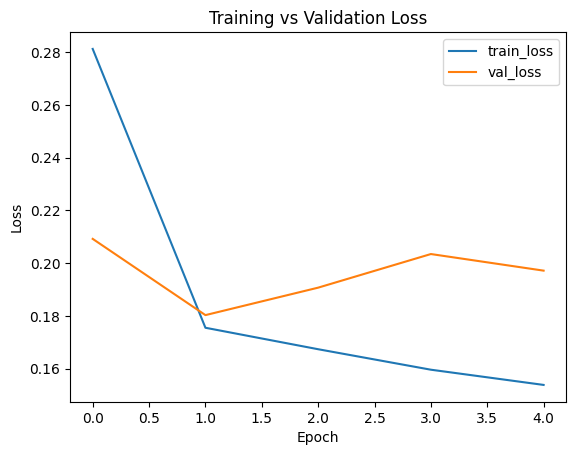

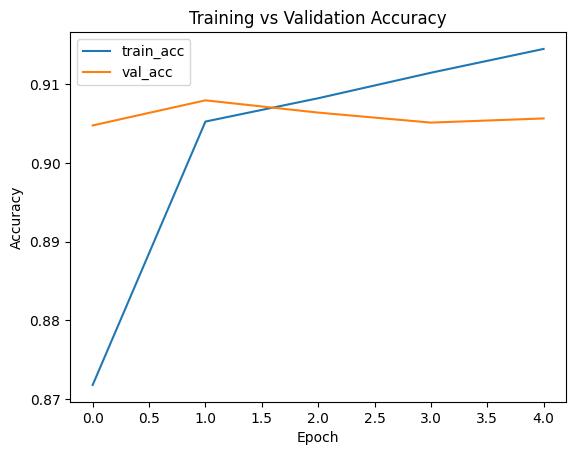

In [ ]:
tf.keras.utils.plot_model(bpe_model, to_file='bpe_model.png', show_shapes=True, show_layer_names=True)

print(history.history.keys())

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

if "accuracy" in history.history:
    plt.figure()
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training vs Validation Accuracy")
    plt.show()

In [ ]:
### Test on new sentences

def encode_one(sentence_piece, text: str, max_len: int, pad_id: int = 3):
    ids = sentence_piece.encode(text.strip(), out_type=int)
    ids = ids[:max_len]
    mask = [1] * len(ids)
    while len(ids) < max_len:
            ids.append(pad_id)
            mask.append(0)    
    return np.array([ids], dtype=np.int32), np.array([mask], dtype=np.int32)
    
text_samples = [
    "I have work tomorrow and I am not looking forward to it.",
    "I feel happy",
    "I have work tomorrow and I am looking forward to it.",
    "I have work tomorrow and I am not looking forward to it, but I love my job.",
    "I love my job and I am looking forward to work tomorrow."   
]

for text in text_samples:
    ids, m = encode_one(sp_bpe, text, TOKEN_LENGTH)
    probs = bpe_model.predict((ids, m), verbose=0)[0]
    pred = int(np.argmax(probs))
    print(f"Text: {text}\nPredicted Emotion: {emotion_map[pred]}")
    
    top3 = np.argsort(probs)[-3:][::-1]
    
    print(f"Top 3 Predictions:")
    for top in top3:
        print(f"{emotion_map[top]}: {probs[top]:.2f}")
        
    print()

Text: I have work tomorrow and I am not looking forward to it.
Predicted Emotion: anger
Top 3 Predictions:
anger: 0.65
sadness: 0.12
joy: 0.11

Text: I feel happy
Predicted Emotion: joy
Top 3 Predictions:
joy: 0.99
anger: 0.01
sadness: 0.00

Text: I have work tomorrow and I am looking forward to it.
Predicted Emotion: anger
Top 3 Predictions:
anger: 0.66
joy: 0.13
fear: 0.13

Text: I have work tomorrow and I am not looking forward to it, but I love my job.
Predicted Emotion: anger
Top 3 Predictions:
anger: 0.57
sadness: 0.16
joy: 0.14

Text: I love my job and I am looking forward to work tomorrow.
Predicted Emotion: anger
Top 3 Predictions:
anger: 0.56
joy: 0.19
sadness: 0.13

